# 空间滤波

滤波是指接受或拒绝一定的频率成分。

线性空间滤波和频率域滤波有着一一对应的关系。

空间滤波可以提供相当多的功能，可以用于非线性滤波，这是在频率域中做不到的。

## 原理

空间滤波器由以下两个部分组成：

1. 一个邻域（通常是一个矩形）
2. 对该邻域所包围图像像素执行的预定义操作

滤波将产生一个像素，新像素的坐标等于领域中心的坐标，像素的值是滤波操作的结果，用数学语言表示为

$$
    g(x, y) = \sum_{s = -a}^{a}\sum_{t = -b}^{a}w(s, t)f(x + s, y + t)
$$

其中，$g$称为滤波器的**响应**，$w$是系数

### 相关、卷积

**相关**是指滤波器模板移过图像并计算每个位置乘积之和的处理。

**卷积**处理的时候滤波器首先要旋转$180^{o}$

下面在一维里理解一下这两个概念

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [40]:
def my_filter(f, w):
    temp = np.hstack((np.zeros(w.size - 1), f, np.zeros(w.size - 1)))
    res = np.array([])
    for i in range(temp.size - w.size + 1):
        res = np.hstack((res, np.dot(temp[i : i + w.size], w.T)))
    return res

def my_convolution(f, w):
    temp = np.hstack((np.zeros(w.size - 1), f, np.zeros(w.size - 1)))
    res = np.array([])
    for i in range(temp.size - w.size + 1):
        res = np.hstack((res, np.dot(temp[i : i + w.size], w[::-1].T)))
    return res

In [44]:
f = np.array([0, 0, 0, 1, 0, 0, 0, 0])
w = np.array([1, 2, 3, 2, 8])
print(my_filter(f, w))
print(my_convolution(f, w))
print(np.convolve(f, w)) # 内置函数结果

[0. 0. 0. 8. 2. 3. 2. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 2. 3. 2. 8. 0. 0. 0. 0.]
[0 0 0 1 2 3 2 8 0 0 0 0]


图像化一下来看

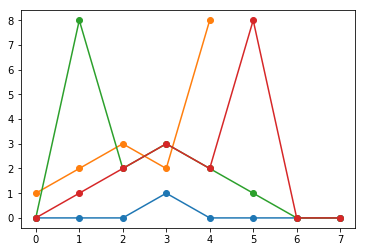

In [37]:
plt.plot(f, 'o-', w, 'o-', my_filter(f, w), 'o-', my_convolution(f, w), 'o-')
plt.show()

这样看起来不有趣，我们拿一个正弦波卷积试一下

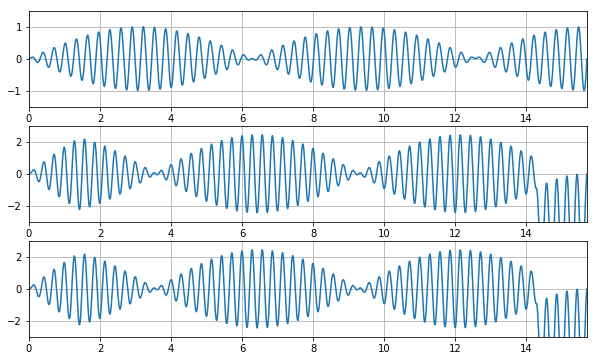

In [46]:
x = np.linspace(0, 5 * np.pi, 1000)
y = np.sin(0.5 * x) * np.sin(20 * x)
w = np.ones(100)

plt.figure(figsize = (10, 6))

plt.subplot(311)
plt.plot(x, y)
plt.axis([0, 5 * np.pi, -1.5, 1.5])
plt.grid(True)

corr = my_filter(y, w) # 相关
plt.subplot(312)
plt.plot(np.linspace(0, 5 * np.pi, corr.size), corr)
plt.axis([0, 5 * np.pi, -3, 3])
plt.grid(True)

conv = my_convolution(y, w) # 卷积
plt.subplot(313)
plt.plot(np.linspace(0, 5 * np.pi, conv.size), conv)
plt.axis([0, 5 * np.pi, -3, 3])
plt.grid(True)
plt.show()

从上面我们知道，卷积和相关无非是把核反转，其他的操作是相同的。在二维的情况下，卷积核就是一个$N\times M$的矩阵，要做的是先将其反转过来：

In [51]:
x = np.arange(1, 10).reshape((3, 3))

In [52]:
x

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [53]:
x[::-1, ::-1]

array([[9, 8, 7],
       [6, 5, 4],
       [3, 2, 1]])

在计算的时候，将每个点都与核分别相乘相加，这个过程就不用代码实现了。这里进一步涉及到一些问题：卷积核如何选取？一种卷积核能够达到什么目的？应该如何去证明？

In [60]:
def convolution_2D(f, w):
    temp = np.zeros((f.shape[0] + 2 * w.shape[0] - 2, f.shape[1] + 2 * w.shape[1] - 2))
    temp[w.shape[0] - 1 : -(w.shape[0] - 1), w.shape[1] - 1 : -(w.shape[1] - 1)] = f.copy()
    return temp

### 编程相关

现在暂停一下，让我们把目光转到编程上来。从卷积开始，自己编写的函数变得臃肿，而且经常需要编写重复的代码：对图像的边界扩展（以便进行卷积运算）、对矩阵的每一个元素进行遍历，而附加在每个元素上的运算越来越复杂。这就带来了一些编程上的困难，下面就来梳理一下：

Numpy和OpenCV给图像处理提供了许多很好的函数。在第一章中我们实现了一个`expand`函数，但是在图像处理中，边界的扩展有很多种，可以全部置零，也可以镜像，还可以对边界进行复制，而这都可以用OpenCV提供的`copyMakeBorder`函数来实现：

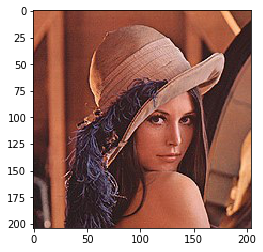

In [93]:
img = cv.imread('lena.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

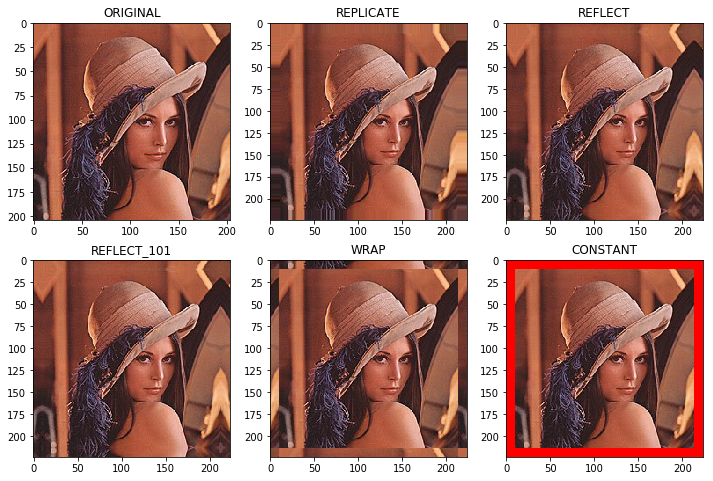

In [94]:
replicate = cv.copyMakeBorder(img,10,10,10,10,cv.BORDER_REPLICATE)
reflect = cv.copyMakeBorder(img,10,10,10,10,cv.BORDER_REFLECT)
reflect101 = cv.copyMakeBorder(img,10,10,10,10,cv.BORDER_REFLECT_101)
wrap = cv.copyMakeBorder(img,10,10,10,10,cv.BORDER_WRAP)
constant = cv.copyMakeBorder(img,10,10,10,10,cv.BORDER_CONSTANT,value=[255, 0, 0])

plt.figure(figsize = (12, 8))
plt.subplot(231),plt.imshow(img,'gray'),plt.title('ORIGINAL')
plt.subplot(232),plt.imshow(replicate,'gray'),plt.title('REPLICATE')
plt.subplot(233),plt.imshow(reflect,'gray'),plt.title('REFLECT')
plt.subplot(234),plt.imshow(reflect101,'gray'),plt.title('REFLECT_101')
plt.subplot(235),plt.imshow(wrap,'gray'),plt.title('WRAP')
plt.subplot(236),plt.imshow(constant,'gray'),plt.title('CONSTANT')
plt.show()

在Numpy中，提供了很多可供代码优化的手段，特别是和MATLAB类似的向量化手段。比如卷积操作，可以采用矩阵点乘代替循环。

还有就是自定义的向量化函数。在Numpy中的内置函数都是可以直接作用在矩阵中的，这就是向量化函数。但是用户自定义的函数不能这样做，最多用函数式编程的方法很蹩脚地写出来。Numpy中内置了两种方法`frompyfunc`和`vectorize`，可以将用户自定义的函数封装为向量化函数。它们的函数原型分别是：

```
numpy.frompyfunc(func, nin, nout)

class numpy.vectorize(pyfunc, otypes=None, doc=None, excluded=None, cache=False, signature=None)
```

其中，第一个函数是属于比较底层的封装方法，得到的是一个向量化函数，得到的这个向量化函数在使用的时候有时可能返回Object类型，使用的时候需要用`astype`方法进行转换。第二个方法高级得多，得到的也是一个向量化函数，但是可以指定返回类型，定义文档等等。

In [74]:
def myfunc(a, b):
    if a < b:
        return a - b
    else:
        return a + b

In [78]:
func1 = np.frompyfunc(myfunc, 2, 1)
func1

<ufunc '? (vectorized)'>

In [79]:
func2 = np.vectorize(myfunc)
func2

In [86]:
res1 = func1([1, 2, 3, 4, 5], [5, 4, 3, 2, 1])
res2 = func2([1, 2, 3, 4, 5], [5, 4, 3, 2, 1])
print(res1)
print(res2)
print(type(res1))
print(type(res2))
print(type(res1[0]))
print(type(res2[0]))

[-4 -2 6 6 6]
[-4 -2  6  6  6]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'numpy.int32'>


### 实现一个通用线性空间滤波器

在MATLAB中，有`imfilter`实现了一个通用的图像滤波器，下面以该函数为模板，自己实现一个。MATLAB脚本的效果在`space_filter.m`中，Python代码实现在`线性空间滤波器.py`中。

下面的脚本实现的是一个平滑空间滤波器

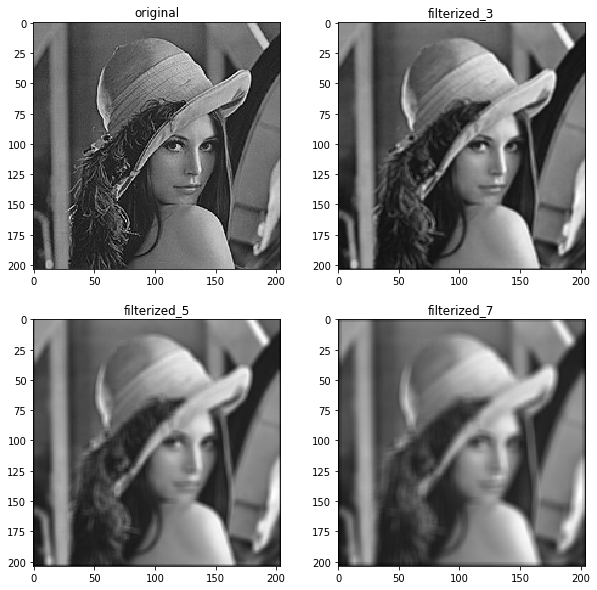

In [101]:
import 线性空间滤波器 as myfilter
img = cv.imread('lena.jpg', 0)
plt.figure(figsize = (10, 10))
plt.subplot(221), plt.imshow(img, cmap = 'gray'), plt.title('original')
plt.subplot(222)
plt.imshow(myfilter.imfilter(img, np.ones((3, 3)), size = 'same'), cmap = 'gray')
plt.title('filterized_3')
plt.subplot(223)
plt.imshow(myfilter.imfilter(img, np.ones((5, 5)), size = 'same'), cmap = 'gray')
plt.title('filterized_5')
plt.subplot(224)
plt.imshow(myfilter.imfilter(img, np.ones((7, 7)), size = 'same'), cmap = 'gray')
plt.title('filterized_7')
plt.show()

可以看到，随着$w$面积的变大，输出图像中的边界部分会产生一条黑边，这就是因为在填充边界的时候，只是简单地使用了一个黑色填充，如果换一种形式，就可以看到那道黑边消失了：

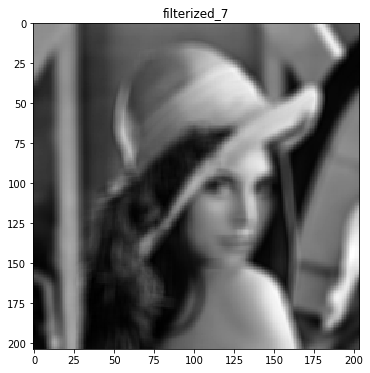

In [103]:
plt.figure(figsize = (6, 6))
plt.imshow(myfilter.imfilter(img, np.ones((7, 7)), expand = 'replicate', size = 'same'), cmap = 'gray')
plt.title('filterized_7')
plt.show()